#### meeting the assumptions of linear regression

In the previous checkpoint, we saw that OLS pins down the coefficients of the linear regression model by minimizing the sum of the model's squared error terms. However, in order for estimated coefficients to be valid and test statistics associated with them to be reliable, some assumptions about the data and the model should be met. These assumptions are known as **Gauss Markov Assumptions or Gauss Markov Conditions**. In this checkpoint, we'll review these assumptions using our medical costs model from the previous checkpoint.

**Before interpreting the estimated coefficients of a linear regression model, it's always a good idea to check whether the Gauss Markov assumptions hold. Otherwise, we need to try to fix our model**. Sometimes this means applying a technique to solve for a specific problem. But **usually, we need to change our model by including additional variables or excluding problematic ones**. Once we have corrected our model, we can then re-estimate it using OLS and check whether or not the Gauss Markov conditions are met. As you will see, this is an iterative process.

A remark on the exact number of Gauss Markov Conditions: Don't get surprised if you see in some places that the number of Gauss Markov Conditions is four, five, or six! This is because some of the conditions can be derived from the others. **For the sake of clarity, we'll introduce Gauss Markov Conditions in six bullets.

Here are the main topics we'll cover in this checkpoint:

    linearity of models in their coefficients
    the error term should be zero on average
    homoscedasticity
    low multicollinearity
    error terms should be uncorrelated with one another
    features shouldn't be correlated with the errors
    normality of the errors

This checkpoint ends with two assignments. First, you'll build a model using a weather dataset and check whether the Gauss Markov Assumptions hold or not. Second, you'll review your house price model from the previous checkpoint from the perspective of the Gauss Markov assumptions.


##### Our medical costs model

We'll use our medical costs model from the previous checkpoint to demonstrate Gauss Markov conditions. First, we need to import the relevant libraries and do the feature engineering steps. Then we will fit our model using OLS.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


In [3]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

In [4]:
# Y is the target variable
Y = insurance_df['charges']
# X is the feature set which includes
# is_male and is_smoker variables
X = insurance_df[['is_male','is_smoker']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37868556 23622.13598049]

Intercept: 
 8466.035592512448


###### Assumption one: linearity of the model in its coefficients

The first assumption that must be met is that **the target variable should be a linear function of the model's coefficients**. People often confuse this condition by **incorrectly thinking that the relationship between target and features must be linear in the sense of being a straight line. But this need not be the case. The relationship could be quadratic or higher order.** A model like (eq.1) below is completely valid:

        𝑦=𝛽0+𝛽1𝑥1+𝛽2𝑥22+𝜖    (𝑒𝑞.1)

As we mentioned earlier, **linear regression modeling is quite flexible in capturing non-linear relationships between target and features.** For example, in (eq.1), the relationship between the 𝑦 and 𝑥 is indeed quadratic. Below, we show how linear regression correctly estimates the intercept and the coefficients of the following model using synthetic data:

        𝑦=1+2𝑥1+3𝑥21          (𝑒𝑞.2)


Coefficients: 
 [2. 3.]

Intercept: 
 0.999999999650754


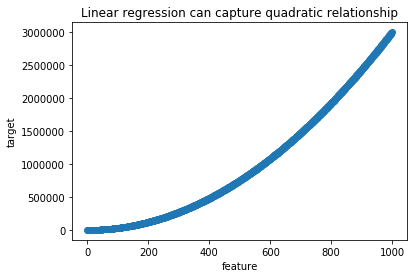

In [5]:
df = pd.DataFrame()

# data from 0 to 999
df["X"] = np.arange(0,1000,1)
# we take the square of X
df["X_sq"] = df["X"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

As you can see, the linear regression model correctly estimated the true coefficients and captured the quadratic relationship between the target and the feature.

In contrast, a model like the one below is an **invalid one as it violates the linearity assumption:

        𝑦=𝛽0+𝛽1𝑥1+𝛽21𝑥1+𝜖      (𝑒𝑞.2)

The relationship between the target 𝑦 and the coefficient 𝛽1 is said to be **non-linear because if we hold all independent variables 𝑥 and other coefficients constant, the graph of 𝑦 for changing 𝛽1 is not a straight line.

In principle, this assumption is **not related to estimation but to how we specify our model. So as long as we use models that take into account this linearity assumption as we did in our medical costs example, then we shouldn't worry about this assumption at all.

##### Assumption two: the error term should be zero on average

This **second assumption states that the expected value of the error term should be zero.** In mathematical terms:

        𝔼(𝜖)=0

The 𝔼 symbol indicates the **expectation operator**. We can read it as ***"the average of the error terms should be equal to zero"***. The error term accounts for the variation in the target variable that is not explained by the features. So, **ideally, the error term shouldn't explain anything in the variation of the target variable but instead should be determined randomly. If the expected value of the error is different than zero, our model would become biased!** For example, if 𝔼(𝜖)=−1, then it means that our model systematically overpredicts the target variable.

**This assumption is not held if you forget to include the constant term in your model.** This is why we said that you should always include a constant in your model. **As long as we include a constant in a model, we shouldn't be worried about this assumption as the constant will force the error terms to be zero on average.

In our medical costs model, we can see this happening:

In [6]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -7.477161225337976e-14


Since, we include the constant term in the model, the average of the model's error is effectively zero.

##### Assumption three: homoscedasticity

The **third assumption is the requirement of homoscedasticity**. A model is **homoscedastic when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. In other words, the error variance shouldn't systematically change across observations.** When this assumption is **not met, we are dealing with heteroscedasticity.**

For example, if our error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This **leads to overconfidence in the accuracy of our model's predictions.**

Let's checkout whether our medical costs model suffers from heteroscedasticity by visualizing it:


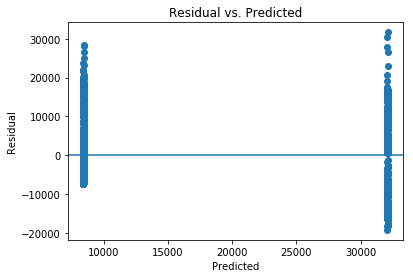

In [7]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It **seems that error variance is higher for the higher values of the target variable. This implies that our error terms aren't homoscedastic**. However, deriving conclusions from visuals is only an informal way of figuring out the problem. Thankfully, there are **several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms.**

Here, we demonstrate two of them: **Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic.** Both tests can be imported from scipy's stats module.


In [8]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 78.9785 and p value is 6.28e-19
Levene test statistic value is 6.87294 and p value is 0.0088


**The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.**

There may be **several causes of heteroscedasticity.** Examples include **outliers in the data and omitted variables that are important in explaining the variance of the target variable.** Dealing with outliers and including relevant variables help to fix the heteroscedasticity problem. Some **fixes to heteroscedasticity include transforming the dependent variable (see Box Cox transformation and log transformation) and adding features that target the poorly-estimated areas.**

If you are **working on a dataset that has a limited number of features and your model suffers from heteroscedasticity because of omitted variables, then fixing this problem is not easy.** However, keep in mind that **even though your model suffers from the heteroscedasticity, the estimated coefficients are still valid (more formally, they are consistent** but we will not discuss consistency of the estimations in this module. If you're interested, you can read about it in this Wikipedia article). The **only problem is with the reliability of some statistical tests like t-test. Heteroscedasticity may make some estimated coefficients seem to be statistically insignificant.** We'll discuss statistical significance in the next checkpoint.


##### Assumption four: low multicollinearity

**Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. When features are correlated, they may both explain the same pattern of variance in the outcome.** The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained. However, **if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

If there is correlation of 1 or -1 between a variable and another or several variables, this is called **perfect multicollinearity**. It is easy to understand perfect collinearity between two variables. But how can one variable be correlated with several variables? **This happens when one variable is a linear combination of the others.

A remark on dummy variables: **Caution is needed when working with dummy variables because of this linear combination issue. If we create some dummy variables from a categorical variable, then we need to exclude one of them from the model.** This is because any one of those dummy variables can be represented as 1 minus the sum of the others. Hence a perfect multicollinearity occurs.

To **detect multicollinearity, we can simply look at the correlation matrix of the features. Multicollinearity can be fixed by PCA or by discarding some of the correlated features.


##### Assumption five: error terms should be uncorrelated with one another

Error terms should be uncorrelated with one another. In other words, **the error term for one observation shouldn't predict the error term for another. This type of serial correlation may happen if we omit a relevant variable from the model. So, including that variable into the model can solve for this issue.

**To identify whether the error terms are correlated with each other or not, we can graph them. In the graph, we need to observe randomness.

Let's check our medical costs model's errors:


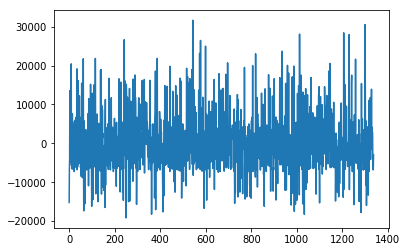

In [9]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

Another way to look at correlations between errors is to use the **autocorrelation function. This function computes the correlation of a variable with itself.** In our case, the order of the errors are the orders of the observations. We can use the acf() function from statsmodels as follows:


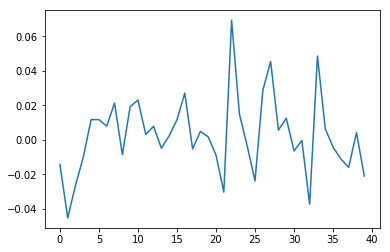

In [10]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of our medical costs model is indeed very low (ranging between -0.06 and 0.05).

##### Assumption six: features shouldn't be correlated with the errors

Last but definitely not least, and **arguably the most important assumption: explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased.** This assumption is **known as the exogeneity.

Violations of the exogeneity assumption **may have several sources. Common causes are omitted variables and simultaneous causation between independent variables and the target. If the problem stems from simultaneous causation then we need to apply some advanced techniques to solve for the issue** but this is beyond the scope of this bootcamp.


##### A very important remark on the normality of the errors

So far in this checkpoint, we've covered six assumptions for OLS regression. **Another important thing to consider is the normality of the error terms.** Although it is **not an assumption of OLS, it still can impact our results.** Specifically, normality of errors is not required to apply OLS to a linear regression model, **but in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed. We'll cover t- and F-tests, which rest upon the normality of the errors in the next checkpoint.

**More often than not, non-normally distributed errors stem from omitted variables. Including the omitted relevant features to the model may help fix the issue.** Sometimes, transforming the dependent variable also helps.

There are **various ways to check for normality of error terms. An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:


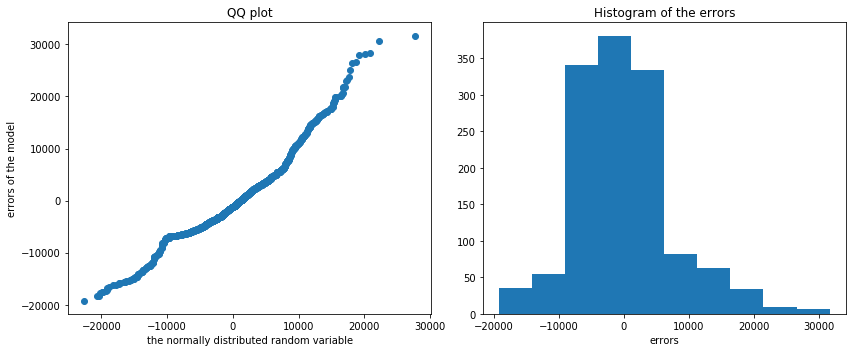

In [11]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, our errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

While visualizations give us a first impression about normality, the best way to learn about this is to apply formal statistical tests. To this end, we use two of them from scipy's stats module: **Jarque Bera and normal tests. The null hypothesis of both tests is that the errors are normally distributed.

Let's use these tests to find out whether our error terms are normally distributed or not:


In [13]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [14]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 211.89696216982128 and p value is 0.0
Normality test statistics is 135.8419839939868 and p value is 3.178981278604034e-30


The p-values of both tests indicate that our errors are not normally distributed.

##### Assignments

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below
1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    First, load the dataset from the weatherinszeged table from Thinkful's database.
    Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
    Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.
2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    Load the houseprices data from Thinkful's database.
    Reimplement the model you built in the previous checkpoint.
    Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
    be sure to close the database connection after initially pulling in your data.

